In [ ]:
!pip install transformers

     |████████████████████████████████| 1.5MB 7.7MB/s 
     |████████████████████████████████| 890kB 28.8MB/s 
     |████████████████████████████████| 2.9MB 19.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=ba82f5282f83ab25563581bb6744b0289b3a0fe5d0bdf0b6aceed8202c621c28
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold, train_test_split
import matplotlib.pyplot as plt
from wordcloud import WordCloud ,STOPWORDS
from tqdm.notebook import tqdm
import tensorflow as tf
# import bert_tokenization as tokenization
import tensorflow.keras.backend as K
import os
from transformers import *
from transformers import TFBertModel, BertModel

import seaborn as sns
sns.set_theme()
import string
import re    

np.set_printoptions(suppress=True)

import warnings
warnings.filterwarnings("ignore")

##Reading dataset and preprocessing 

In [ ]:
df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)
df = df.drop('article_link', axis=1)

In [ ]:
df.dtypes

is_sarcastic     int64
headline        object
dtype: object

In [ ]:
df

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...
...,...,...
28614,1,jews to celebrate rosh hashasha or something
28615,1,internal affairs investigator disappointed con...
28616,0,the most beautiful acceptance speech this week...
28617,1,mars probe destroyed by orbiting spielberg-gat...


##Data description and visualization

In [ ]:
df['is_sarcastic'].value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

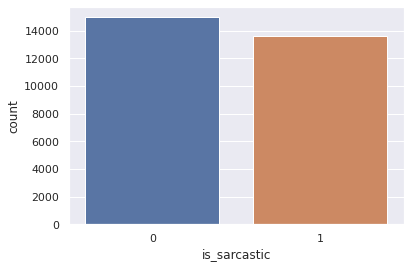

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(df['is_sarcastic'])

As we can see, data is quite balanced

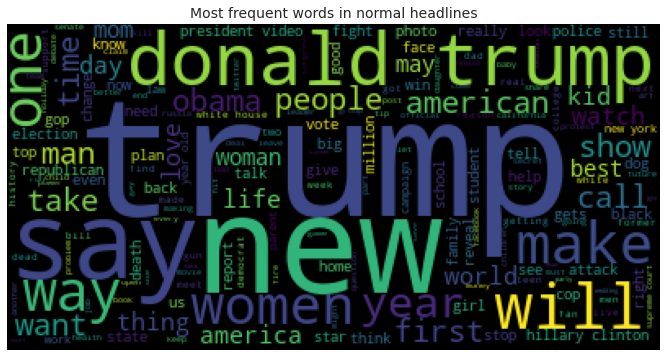

In [ ]:
no_sarc = df.loc[df['is_sarcastic'] == 0]['headline'].values
wc = WordCloud(background_color="black",max_words=1000,stopwords=STOPWORDS)
wc.generate(" ".join(no_sarc))
plt.figure(figsize=(12,6))
plt.axis("off")
plt.title("Most frequent words in normal headlines", fontsize=14)
plt.imshow(wc)
plt.show()

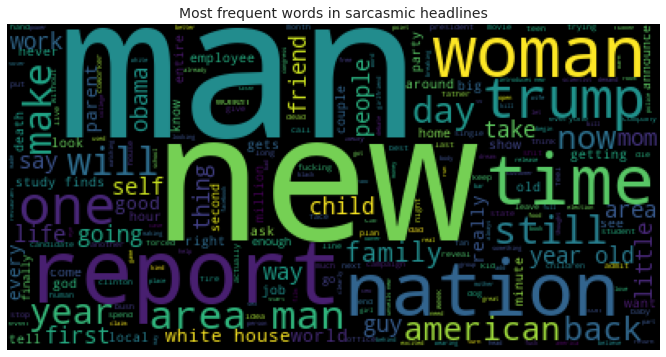

In [ ]:
sarc = df.loc[df['is_sarcastic'] == 1]['headline'].values
wc = WordCloud(background_color="black",max_words=1000,stopwords=STOPWORDS)
wc.generate(" ".join(sarc))
plt.figure(figsize=(12,6))
plt.axis("off")
plt.title("Most frequent words in sarcasmic headlines", fontsize=14)
plt.imshow(wc)
plt.show()

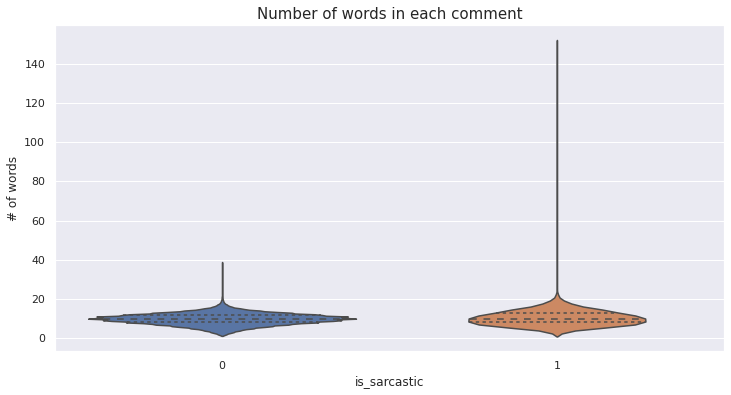

In [ ]:
df['count_word'] = df['headline'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12,6))
sns.violinplot(y='count_word',x='is_sarcastic', data=df, split=True, inner="quart")
plt.xlabel('is_sarcastic', fontsize=12)
plt.ylabel('# of words', fontsize=12)
plt.title("Number of words in each comment", fontsize=15)
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfv = TfidfVectorizer(min_df=100,  max_features=10000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

vecs = tfv.fit_transform(df['headline'].values)
features = np.array(tfv.get_feature_names())

In [ ]:
def top_tfidf_feats(row, features, top_n=15):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [ ]:
def top_feats_in_doc(Xtr, features, row_id, top_n=15):
  ''' Top tfidf features in specific document (matrix row) '''
  row = np.squeeze(Xtr[row_id].toarray())
  return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=15):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [ ]:
def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=15):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [ ]:
tfidf_top_n_per_lass = top_feats_by_class(vecs,df['is_sarcastic'].values,features) 

Text(0, 0.5, 'TF-IDF score')

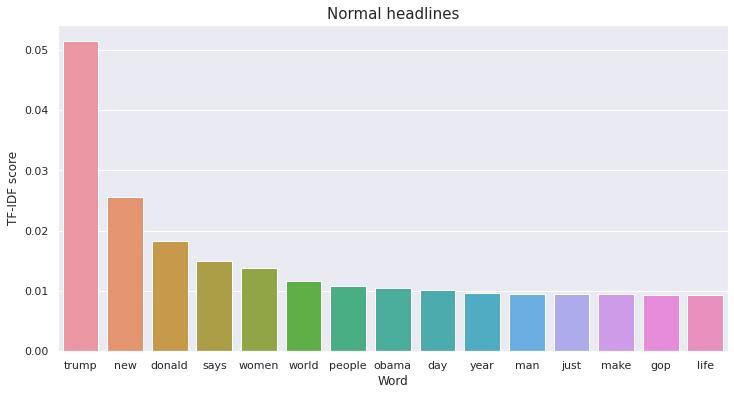

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(tfidf_top_n_per_lass[0].feature,tfidf_top_n_per_lass[0].tfidf)
plt.title('Normal headlines',fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

Text(0, 0.5, 'TF-IDF score')

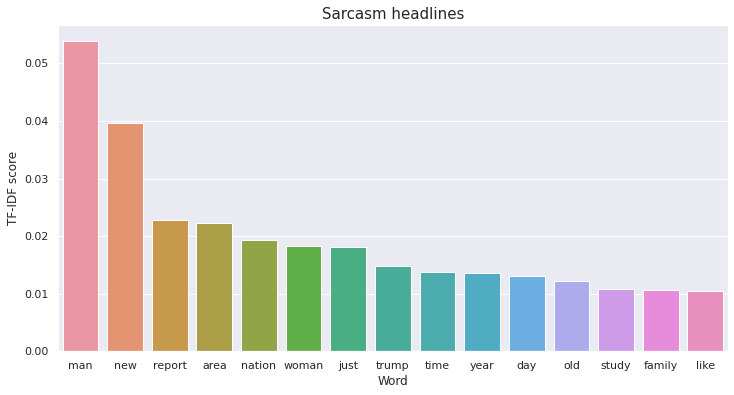

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(tfidf_top_n_per_lass[1].feature,tfidf_top_n_per_lass[1].tfidf)
plt.title('Sarcasm headlines', fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

In [ ]:
tfv_bigram = TfidfVectorizer(min_df=100,  max_features=10000, 
            strip_accents='unicode', analyzer='word',ngram_range=(2,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

bigrams = tfv_bigram.fit_transform(df['headline'].values)
features_bigrams = np.array(tfv_bigram.get_feature_names())

In [ ]:
tfidf_top_bigrams_per_lass = top_feats_by_class(bigrams,df['is_sarcastic'].values,features_bigrams) 

Text(0, 0.5, 'TF-IDF score')

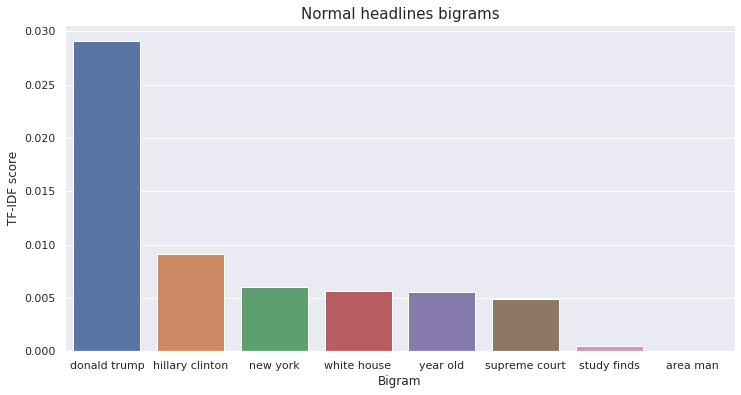

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(tfidf_top_bigrams_per_lass[0].feature,tfidf_top_bigrams_per_lass[0].tfidf)
plt.title('Normal headlines bigrams', fontsize=15)
plt.xlabel('Bigram', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

Text(0, 0.5, 'TF-IDF score')

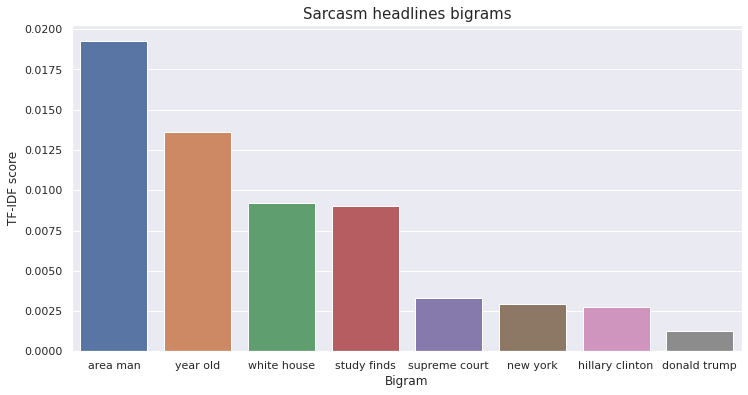

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(tfidf_top_bigrams_per_lass[1].feature, tfidf_top_bigrams_per_lass[1].tfidf)
plt.title('Sarcasm headlines bigrams', fontsize=15)
plt.xlabel('Bigram', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

##Model import and experiments

###Bert base uncase

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case = True)
bert_base = TFBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
%%time

def bert_encode(sentences):
  input_ids = []
  attention_masks = []
  
  for sentence in sentences:
    encoding = tokenizer.encode_plus(
              sentence,
              max_length=64,
              truncation = True,
              add_special_tokens=True,
              return_token_type_ids=False,
              pad_to_max_length=True,
              return_attention_mask=True)
      
    input_ids.append(encoding['input_ids'])
    attention_masks.append(encoding['attention_mask'])
        
  return np.array(input_ids),np.array(attention_masks)


train_sents, test_sents, train_labels, test_labels  = train_test_split(df['headline'].values, df['is_sarcastic'].values, test_size=0.2, random_state=42)

train_ids, train_attention_masks = bert_encode(train_sents)
test_ids, test_attention_masks = bert_encode(test_sents) 

CPU times: user 9.93 s, sys: 39.1 ms, total: 9.97 s
Wall time: 9.98 s


In [ ]:
BATCH_SIZE = 32
DENSE_DIM = 128
DROPOUT = 0.2

In [ ]:
def build_model(model_layer, learning_rate, dense_dim = DENSE_DIM, dropout = DROPOUT):
    
    #define inputs
    input_ids = tf.keras.Input(shape=(64,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(64,),dtype='int32')
    # meta_input = tf.keras.Input(shape = (meta_train.shape[1], ))
    
    #insert BERT layer
    transformer_layer = model_layer([input_ids, attention_masks])

    #inserl dense layers for fine-tuning
    output = tf.keras.layers.Lambda(lambda seq: seq[:, 0, :])(transformer_layer[0])
    output = tf.keras.layers.Dense(dense_dim,activation='relu')(output)   
    output = tf.keras.layers.Dropout(dropout)(output)
    
    #add final node for binary classification
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    
    model = tf.keras.models.Model(inputs = [input_ids, attention_masks],outputs = output)
    model.compile(tf.keras.optimizers.Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
BERT_base = build_model(bert_base, learning_rate = 1e-5)
BERT_base.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fc3a8e98e58> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fc3a8e98e58> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
_____________________________________________________

In [ ]:
#train BERT
history = BERT_base.fit(x = [train_ids,train_attention_masks], y = train_labels, epochs = 3, verbose = 1, batch_size = BATCH_SIZE, validation_data = ([test_ids,test_attention_masks], test_labels))   

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Epoch 1/2


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


716/716 [==============================] - ETA: 0s - loss: 0.3985 - accuracy: 0.8054

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


716/716 [==============================] - 342s 458ms/step - loss: 0.3984 - accuracy: 0.8055 - val_loss: 0.2225 - val_accuracy: 0.9079
Epoch 2/2
716/716 [==============================] - 325s 455ms/step - loss: 0.1561 - accuracy: 0.9381 - val_loss: 0.1822 - val_accuracy: 0.9312


###Bert large uncased

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-large-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case = True)
bert_large = TFBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
train_ids, train_attention_masks = bert_encode(train_sents)
test_ids, test_attention_masks = bert_encode(test_sents) 

In [ ]:
BERT_large = build_model(bert_large, learning_rate = 1e-5)
BERT_large.summary()

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   TFBaseModelOutputWit 335141888   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1024)         0           tf_bert_model_1[0][0]      

In [ ]:
history = BERT_large.fit(x = [train_ids,train_attention_masks], y = train_labels, epochs = 2, verbose = 1, batch_size = BATCH_SIZE, validation_data = ([test_ids,test_attention_masks], test_labels))  

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Epoch 1/2


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


716/716 [==============================] - ETA: 0s - loss: 0.3737 - accuracy: 0.8225

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


716/716 [==============================] - 1037s 1s/step - loss: 0.3736 - accuracy: 0.8226 - val_loss: 0.1793 - val_accuracy: 0.9298
Epoch 2/2
716/716 [==============================] - 1007s 1s/step - loss: 0.1341 - accuracy: 0.9469 - val_loss: 0.1922 - val_accuracy: 0.9333


###DistilBERT base uncased

In [ ]:
PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case = True)
bert_distil = TFBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFBertModel: ['distilbert', 'activation_13', 'vocab_projector', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_ids, train_attention_masks = bert_encode(train_sents)
test_ids, test_attention_masks = bert_encode(test_sents) 

In [ ]:
BERT_dist = build_model(bert_distil, learning_rate = 1e-5)
BERT_dist.summary()

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 64)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_4 (TFBertModel)   TFBaseModelOutputWit 109482240   input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 768)          0           tf_bert_model_4[0][0]      

In [ ]:
history = BERT_dist.fit(x = [train_ids,train_attention_masks], y = train_labels, epochs = 5, verbose = 1, batch_size = BATCH_SIZE, validation_data = ([test_ids,test_attention_masks], test_labels))  

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Epoch 1/5


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


716/716 [==============================] - ETA: 0s - loss: 0.6460 - accuracy: 0.6130

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


716/716 [==============================] - 341s 457ms/step - loss: 0.6459 - accuracy: 0.6131 - val_loss: 0.4042 - val_accuracy: 0.8134
Epoch 2/5
716/716 [==============================] - 326s 456ms/step - loss: 0.3809 - accuracy: 0.8350 - val_loss: 0.3548 - val_accuracy: 0.8452
Epoch 3/5
716/716 [==============================] - 326s 455ms/step - loss: 0.2872 - accuracy: 0.8824 - val_loss: 0.3242 - val_accuracy: 0.8613
Epoch 4/5
716/716 [==============================] - 326s 455ms/step - loss: 0.2340 - accuracy: 0.9070 - val_loss: 0.3209 - val_accuracy: 0.8627
Epoch 5/5
716/716 [==============================] - 326s 456ms/step - loss: 0.1812 - accuracy: 0.9299 - val_loss: 0.3334 - val_accuracy: 0.8693


In [ ]:
res_df = pd.DataFrame(data=[], columns=['Model_name', 'Training_time_in_min', 'Validation_loss', 'Validation_accuracy'])
res_df['Model_name'] = ['BertBased', 'BertLarge', 'DistilBERT']
res_df['Training_time_in_min'] = [11.5, 34, 27.4]
res_df['Validation_loss'] = [0.1822, 0.1922, 0.3334]
res_df['Validation_accuracy'] = [0.9312, 0.9333, 0.8693]

res_df

,Model_name,Training_time_in_min,Validation_loss,Validation_accuracy
0,BertBased,11.5,0.1822,0.9312
1,BertLarge,34.0,0.1922,0.9333
2,DistilBERT,27.4,0.3334,0.8693


What can be done next: </br>
*   Training for more epochs;
*   Adding learning rate shedulers(ReduceLRonPlateau, OneCycleLR, StepLR, etc);
*   Trying other transformer like models(RoBERTa, XLM, GPT-2/3, etc);
*   Trying ensembles of models;
*   Better hyperparameter tuning (learning rate, batch size, max length size, number of dense layers/neurons in layers, etc);
*   Adding meta information to the input (average word length in sentences, number of words in sentences, count of specific words in sentences, etc);
*   Try data augmentation techniques (back translation, NLP Albumentation, random swaps/deletions/insertions, etc).

